# Identified laminin distance from boundary for 1 image + CROP


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import pathlib
from joblib import Parallel, delayed
import napari

from skimage import exposure, measure, util
from skimage.filters import threshold_otsu, gaussian,  threshold_minimum, threshold_local
from skimage.segmentation import clear_border, find_boundaries
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import remove_small_holes, remove_small_objects, closing, opening, ball, erosion, dilation
from skimage.transform import rescale

from scipy.ndimage.morphology import distance_transform_edt
from scipy import ndimage as ndi

from tifffile import imread
import tifffile
from typing import Tuple, List

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from textwrap import wrap
from scipy.signal import argrelextrema

import warnings
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from skimage.segmentation import clear_border, find_boundaries, watershed, expand_labels, mark_boundaries

from skimage.feature import peak_local_max


warnings.filterwarnings('ignore')
plt.rcParams['image.interpolation'] = "None"
global colour 
colour = "black"
COLOR = colour
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR


C:\Users\isobe\AppData\Local\Temp\ipykernel_25172\1375761233.py:17: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt


In [2]:
import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [3]:
def pixel_size(tif_path):
    with tifffile.TiffFile(tif_path) as tif:
        tif_tags = {}
        for tag in tif.pages[0].tags.values():
            name, value = tag.name, tag.value
            tif_tags[name] = value

        x_pixel_size_um = 1/((tif_tags["XResolution"])[0]/(tif_tags["XResolution"][1]))
        y_pixel_size_um = 1/((tif_tags["YResolution"])[0]/(tif_tags["YResolution"][1]))
        try:
            z_pixel_size_um = float(str(tif_tags["IJMetadata"]).split("nscales=")[1].split(",")[2].split("\\nunit")[0])
        except:
            z_pixel_size_um = (float(str(tif_tags["ImageDescription"]).split("spacing=")[1].split("loop")[0]))
       
    original_spacing = [x_pixel_size_um,y_pixel_size_um,z_pixel_size_um]
    return original_spacing

In [4]:
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [5]:
def add_image_details(df, filename, flag):
    df["filename"] = filename
    df["flag"] = flag
    if ("well1" in filename):
        df["well"] = 1
    else:
        df["well"] = 2
    # Day #        
    if "d0" in filename:
        df["day"] =  0
    elif "d1" in filename:
        df["day"] =  1
    elif "d3" in filename:
        df["day"] =  3
    else:
        df["day"] =  7
    # Stiffness
    if 'soft' in filename:
        df["condition"] =  'soft'
    elif 'stiff' in filename:
        df["condition"] =  'stiff'
    else:
        df["condition"] =  'blank'
    df['image_type'] = df["condition"].astype(str) + ", d" + df["day"].astype(str)

    return df

In [6]:
def segment(path, DAPI_channel = 0, membrane_channel = 2, bm_channel=1, to_plot=True, colour="black"): 
    filename = os.path.basename(path).replace("_", "").lower()
    try:
        flag = "None"
        multi_channel_image = convert(imread(path), 0,255, np.uint8)
        acinus_image = (multi_channel_image[:,DAPI_channel,:,:] + multi_channel_image[:,membrane_channel,:,:]) # approximate the acinus as membrane + dapi
        bm_image = (multi_channel_image[:, bm_channel,:,:]) 

        original_spacing = pixel_size(path) #alter the z spacing so x,y,z all have the same pixel size
        scale_change = original_spacing[2] / original_spacing[0]
        acinus_rescaled = rescale(scale = (0.25*scale_change, 0.25, 0.25), image = acinus_image, anti_aliasing= False)
        bm_rescaled = rescale(scale = (0.25*scale_change, 0.25, 0.25), image = bm_image, anti_aliasing= False)
        clipped = acinus_rescaled.clip(min =np.quantile(acinus_rescaled, 0.1), max = np.quantile(acinus_rescaled, 0.85))
        acinus_smoothed = gaussian(clipped, sigma = 9)
        thresh = threshold_otsu(acinus_smoothed)
        binary = acinus_smoothed > thresh

        binary = remove_small_holes(binary, area_threshold = 100000)
        binary = remove_small_objects(binary, min_size = 10000)

        labelled_image = label(binary)
        table = regionprops_table(labelled_image, properties=('label', "area"),) #only keep largest acinus
        condition = (table['area'] >= (table["area"]).max())
        input_labels = table['label']
        output_labels = input_labels * condition
        filtered_labelled_image = util.map_array(labelled_image, input_labels, output_labels)

        table = regionprops_table(filtered_labelled_image, properties=('label', 'inertia_tensor_eigvals'),) #test sphericity of largest identified acinus
        condition = table['inertia_tensor_eigvals-2']/table['inertia_tensor_eigvals-0'] >= (0.55)
################################################################################################################
        if condition == False:
            #low sphericity could mean that 2 neighbouring acini have been imaged. Attempt to separate these with heavy erosion if so
            flag = "multiple_acini_split"
            acinus_smoothed = gaussian(clipped, sigma = 1)
            thresh = threshold_otsu(acinus_smoothed)
            binary = acinus_smoothed > thresh
            binary = remove_small_holes(binary, area_threshold = 100000)
            binary = remove_small_objects(binary, min_size = 10000)
            binary = erosion(binary, ball(8))
            labelled_image = label(binary)
            table = regionprops_table(labelled_image, properties=('label', "area"),)
            condition = (table['area'] >= (table["area"]).max())
            input_labels = table['label']
            output_labels = input_labels * condition
            filtered_labelled_image = util.map_array(labelled_image, input_labels, output_labels)
            filtered_labelled_image = expand_labels(filtered_labelled_image, distance=8)
            
    # ################################################################################################################
        bm_rescaled = bm_rescaled * (filtered_labelled_image) #clean bm image to focus on bm in/around identified acinus
        distance = (distance_transform_edt(filtered_labelled_image))
        r = np.cbrt((3* regionprops(filtered_labelled_image)[0].area)/(4*np.pi))
        distance = distance/r
        intensity_with_distance = pd.DataFrame(zip(np.ravel(distance), np.ravel(bm_rescaled)), columns=['distance/radius', 'bm_intensity'])    
        intensity_with_distance['rounded_distance'] = intensity_with_distance["distance/radius"].apply(lambda x: round(x, 2))
        intensity_with_distance = intensity_with_distance.groupby(['rounded_distance'], as_index=False)["bm_intensity"].mean()

        add_image_details(intensity_with_distance, filename, flag) #fill in df with experimental details extracted from filename
     ################################################################################################################   
        if to_plot == True:
            slice_to_display = int(filtered_labelled_image.shape[0]/2)
            fig, ax = plt.subplots(nrows = 1, ncols = 7, figsize=(20,4))
            ax[0].imshow(20*acinus_rescaled[slice_to_display,:,:] , cmap = "gray")
            ax[1].imshow(acinus_smoothed[slice_to_display,:,:], cmap="gray")
            ax[2].imshow(labelled_image[slice_to_display,:,:], cmap = "gray")
            ax[3].imshow(filtered_labelled_image[slice_to_display,:,:], cmap = "gray")
            ax[4].imshow(distance[slice_to_display,:,:], cmap = "gray")
            ax[5].imshow(bm_rescaled[slice_to_display,:,:], cmap = "gray")
            cols = ["Original", "Clipped",  "Identified Objects", "Largest Acinus", "Distance Map", "Clean BM", "Intensity v Dist"]
            for i in range(6):
                if i !=7:
                    ax[i].set_xticks([])
                    ax[i].set_yticks([])
                ax[i].set_title(cols[i]) 
            
            to_plot = intensity_with_distance.groupby(['rounded_distance'], as_index=False)["bm_intensity"].mean()
            to_plot["bm_intensity"] = to_plot["bm_intensity"]/ to_plot["bm_intensity"].max()
            sns.lineplot(data = to_plot, x="rounded_distance", y = "bm_intensity", ax = ax[-1], color="red")

            plt.savefig("Segmented{}.png".format(colour), bbox_inches="tight", transparent="True")

            return filtered_labelled_image, acinus_rescaled, bm_rescaled,  intensity_with_distance
        else:
            return intensity_with_distance
    except:
        intensity_with_distance = pd.DataFrame()
        intensity_with_distance["filename"] = filename
        intensity_with_distance["flag"]= "IMAGE FAILED"


# Full Run

In [7]:
root = "E:\\PROTEIN_COLOCALISATION_IMAGES\\Deconvolved_Images\\Lam_Pax_DECONVOLVED\\final_tifs"
#root ="E:\\PROTEIN_COLOCALISATION_IMAGES\\Deconvolved_Images\\FINAL_COL_BETA_CAT\\tifs\\using"
#root = "E:\\Deconvolved_Integrin_Investigation_ABT737_Feb2024\\Deconvolved_tif\\ABT737"
image_paths = list(pathlib.Path(root).glob("**/*.tif"))

In [8]:
len(image_paths)

140

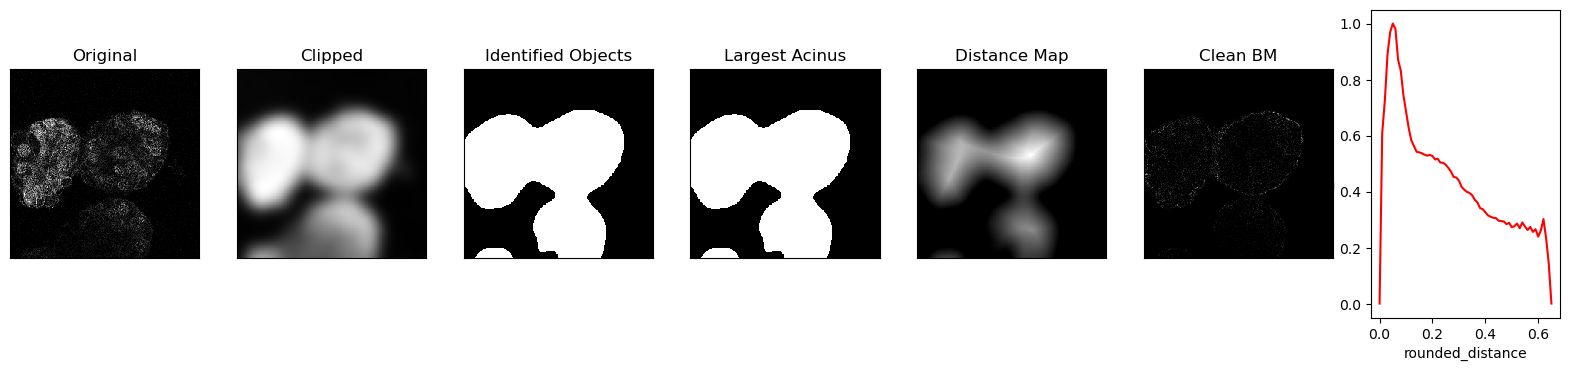

In [10]:
filtered_labelled_image, acinus_rescaled, laminin_rescaled,  intensity_with_distance = segment(image_paths[5], DAPI_channel = 0, membrane_channel = 2, bm_channel=1, to_plot=True)

In [11]:
viewer = napari.Viewer()
viewer.add_image(acinus_rescaled)
viewer.add_labels(filtered_labelled_image)
viewer.add_image(laminin_rescaled)

<Image layer 'laminin_rescaled' at 0x16168683520>

In [12]:
with tqdm_joblib(tqdm(desc="Image Analysis", total=len(image_paths))) as progress_bar:
    intensity_with_distance = Parallel(n_jobs=3)(delayed(segment)(path, to_plot=False, bm_channel=1) for path in image_paths)

Image Analysis: 100%|██████████| 140/140 [31:26<00:00, 13.47s/it]


In [14]:
total = pd.concat(intensity_with_distance).reset_index()

In [15]:
total.head()

,index,rounded_distance,bm_intensity,filename,flag,well,day,condition,image_type
0,0,0.00,0.000000,lampaxd0well11.tif,multiple_acini_split,1,0,blank,"blank, d0"
1,1,0.01,0.003086,lampaxd0well11.tif,multiple_acini_split,1,0,blank,"blank, d0"
2,2,0.02,0.003862,lampaxd0well11.tif,multiple_acini_split,1,0,blank,"blank, d0"
3,3,0.03,0.004164,lampaxd0well11.tif,multiple_acini_split,1,0,blank,"blank, d0"
4,4,0.04,0.004057,lampaxd0well11.tif,multiple_acini_split,1,0,blank,"blank, d0"


In [16]:
total.flag.unique()

array(['multiple_acini_split', 'None'], dtype=object)

In [17]:
total.to_parquet('FINAL_laminin_290424.parquet')

### Clustering images

In [12]:
total = total.to_parquet('1502_raw_intensity_with_distance_first.parquet')

In [42]:
total = total\
    .groupby('Image')\
        .sample(20000)\
            .sort_values(['Image', 'Distance/Radius'])

In [43]:
total.Intensity = total\
    .groupby('Image')\
        .Intensity\
            .apply(lambda group: group.interpolate(method='linear', limit_direction='backward'))

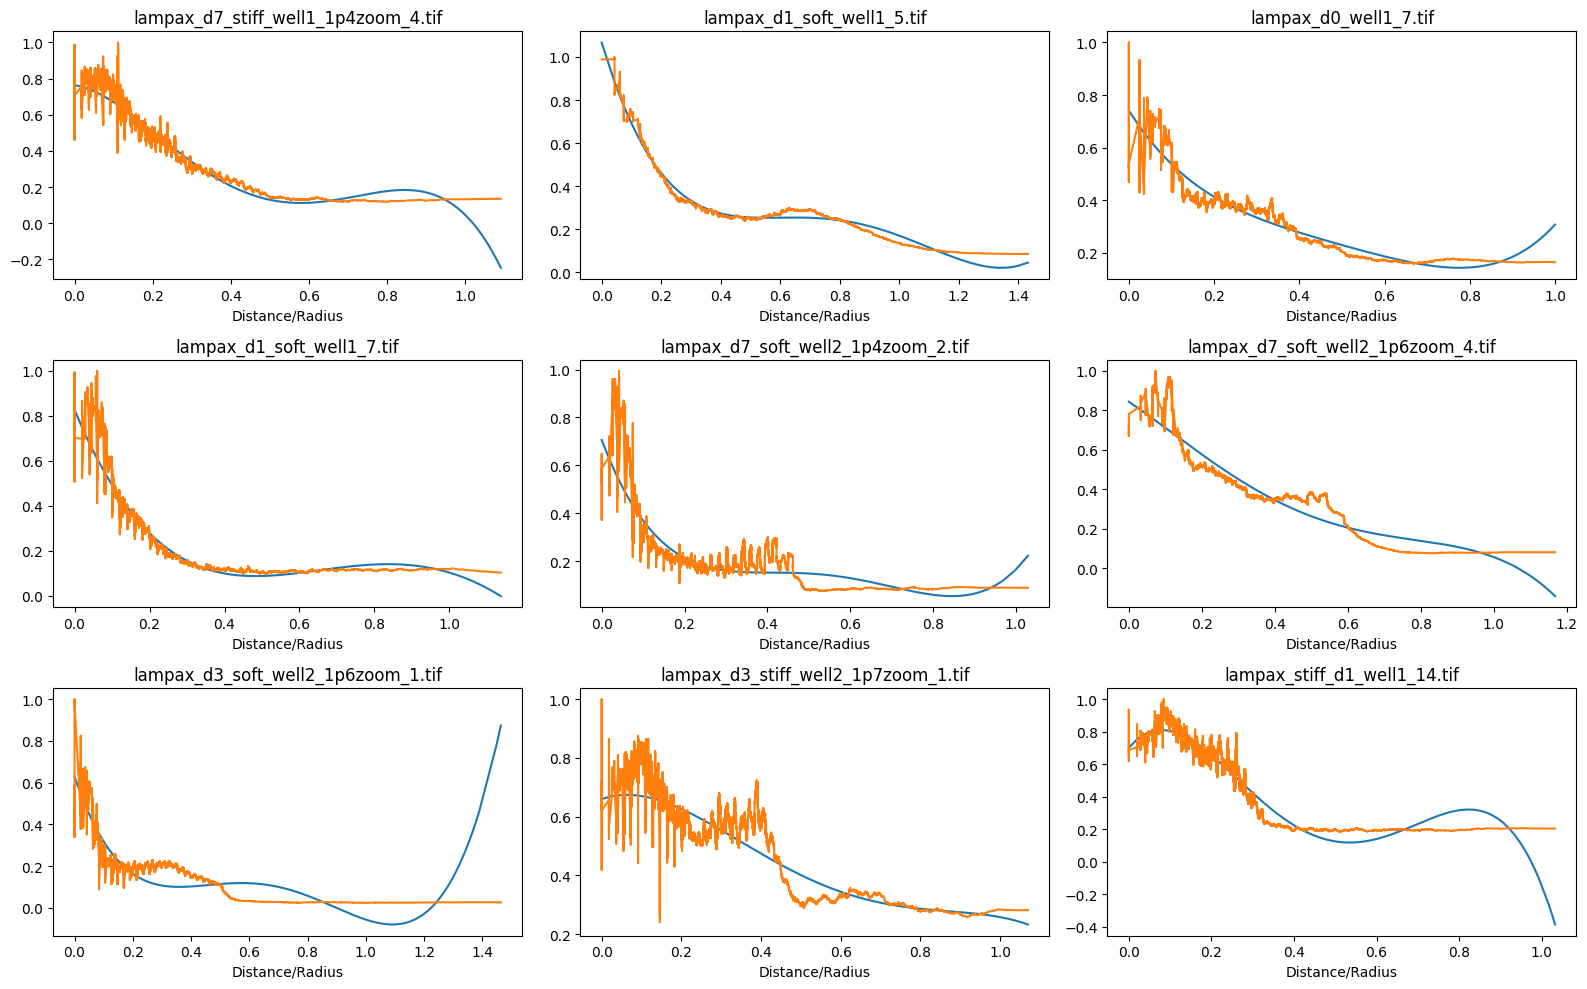

In [13]:
images_to_plot = np.random.choice(total.Image.unique(), 9)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 10))
ax = ax.flatten()

for i, image in enumerate(images_to_plot):
    image_specific_data = total[total.Image == image].set_index('Distance/Radius')
    coefs_ = np.polyfit(image_specific_data.index, image_specific_data.Intensity, 4)
    poly_vals = np.polyval(coefs_, image_specific_data.index)
    ax[i].plot(image_specific_data.index, poly_vals )
    image_specific_data.Intensity.plot(ax=ax[i])
    ax[i].set_title(image)

plt.tight_layout()

In [16]:
def extract_coefficients(image, image_data, degree=3):
    data = [image] + list(np.polyfit(image_data['Distance/Radius'], image_data.Intensity, degree))
    index = ['Image'] + [f'coef_{x}' for x in range(degree+1)[::-1]]
    return pd.Series(data, index=index).to_frame().T

curve_fit_data = [extract_coefficients(x, total[total.Image == x], 4) for x in total.Image.unique()]
curve_fit_data = pd.concat(curve_fit_data)
curve_fit_data = curve_fit_data.set_index('Image')

In [17]:
curve_fit_data = curve_fit_data.astype(float)

In [18]:
clusters = range(2, 21)
inertia = []

for i in clusters:
    kmeans = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=i))
    ])
    kmeans.fit(curve_fit_data)
    inertia.append(kmeans['kmeans'].inertia_)

Text(0.5, 0, 'Clusters')

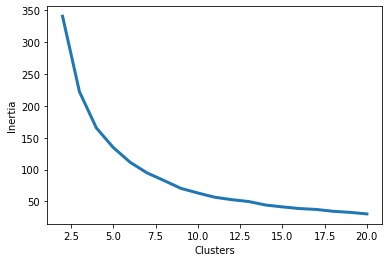

In [19]:
fig, ax = plt.subplots()
ax.plot(clusters, inertia, linewidth=3)
ax.set_ylabel('Inertia')
ax.set_xlabel('Clusters')

In [20]:
kmeans = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=4))
])

kmeans.fit(curve_fit_data)
curve_fit_data['cluster'] = kmeans.predict(curve_fit_data)

In [76]:
cluster_assignment = curve_fit_data.reset_index()[['Image', 'cluster']]
total.drop('cluster', axis=1, inplace=True)
total = total.merge(cluster_assignment)

KeyError: "['cluster'] not found in axis"

In [ ]:
total.cluster.value_counts(normalize=True).sort_index()

0    0.507042
1    0.218310
2    0.077465
3    0.197183
Name: cluster, dtype: float64

In [ ]:
def plot_cluster_images(cluster):
    images_to_plot = np.random.choice(total[total.cluster == cluster].Image.unique(), 9)

    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 10))
    ax = ax.flatten()

    for i, image in enumerate(images_to_plot):
        image_specific_data = total[total.Image == image].set_index('Distance/Radius')
        coefs_ = np.polyfit(image_specific_data.index, image_specific_data.Intensity, 3)
        poly_vals = np.polyval(coefs_, image_specific_data.index)
        ax[i].plot(image_specific_data.index, poly_vals )
        ax[i].set_title(image)
        image_specific_data.Intensity.plot(ax=ax[i])

    plt.tight_layout()

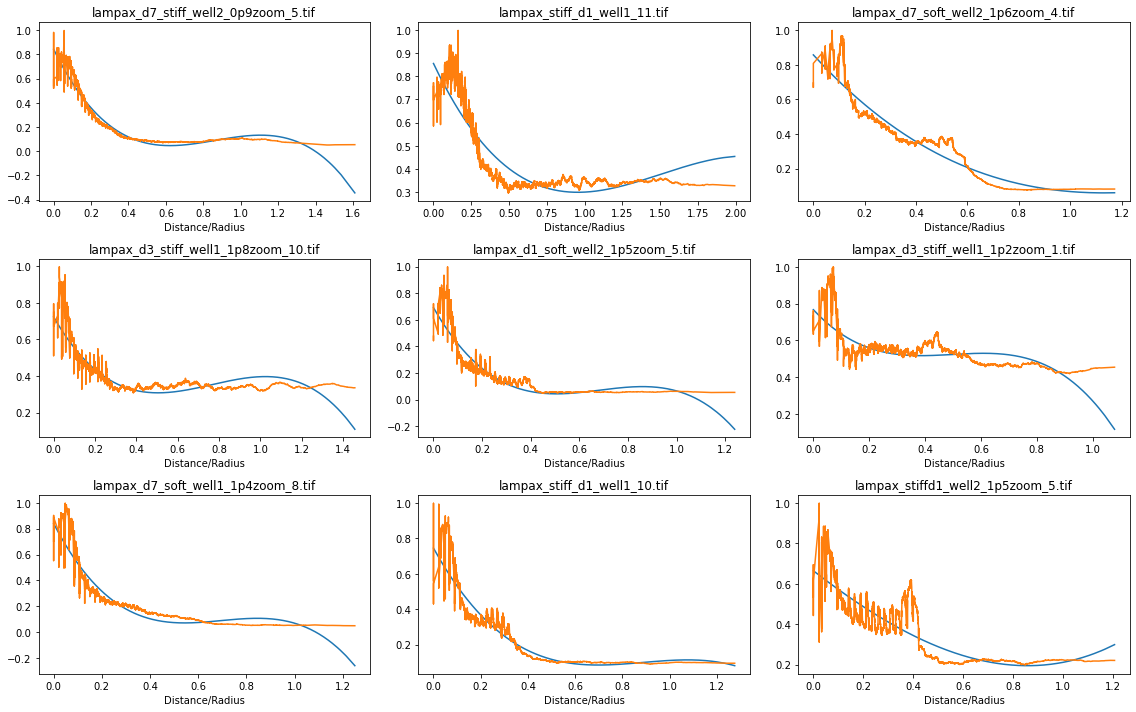

In [ ]:
plot_cluster_images(0)

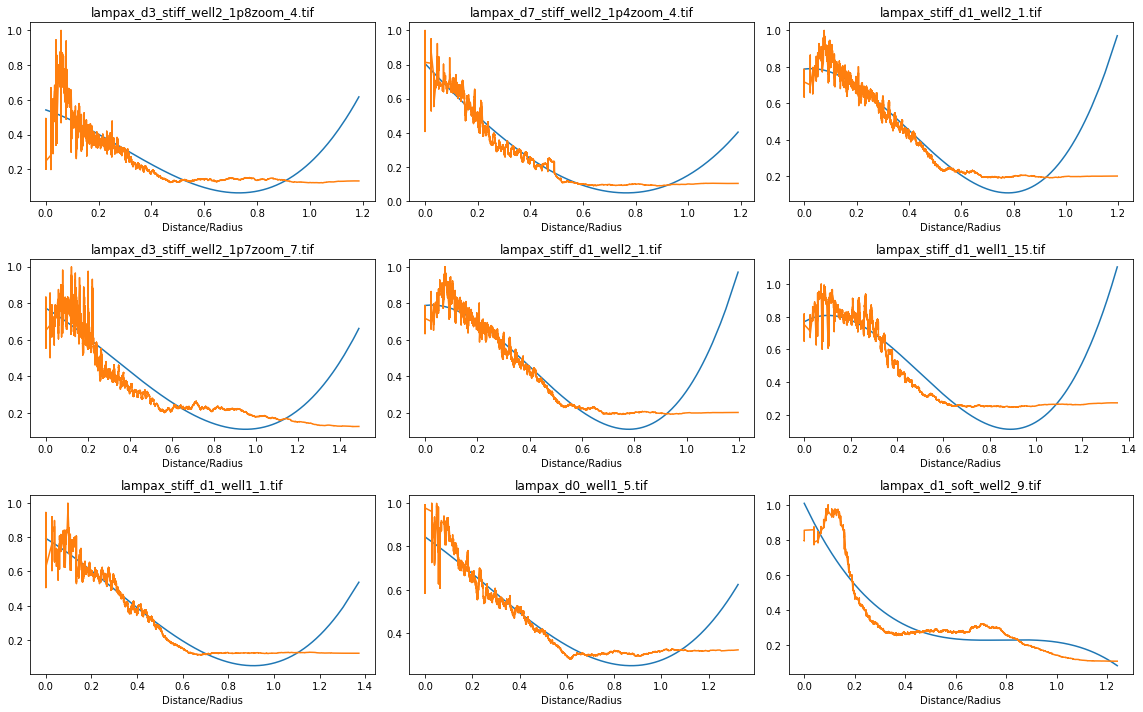

In [ ]:
plot_cluster_images(1)

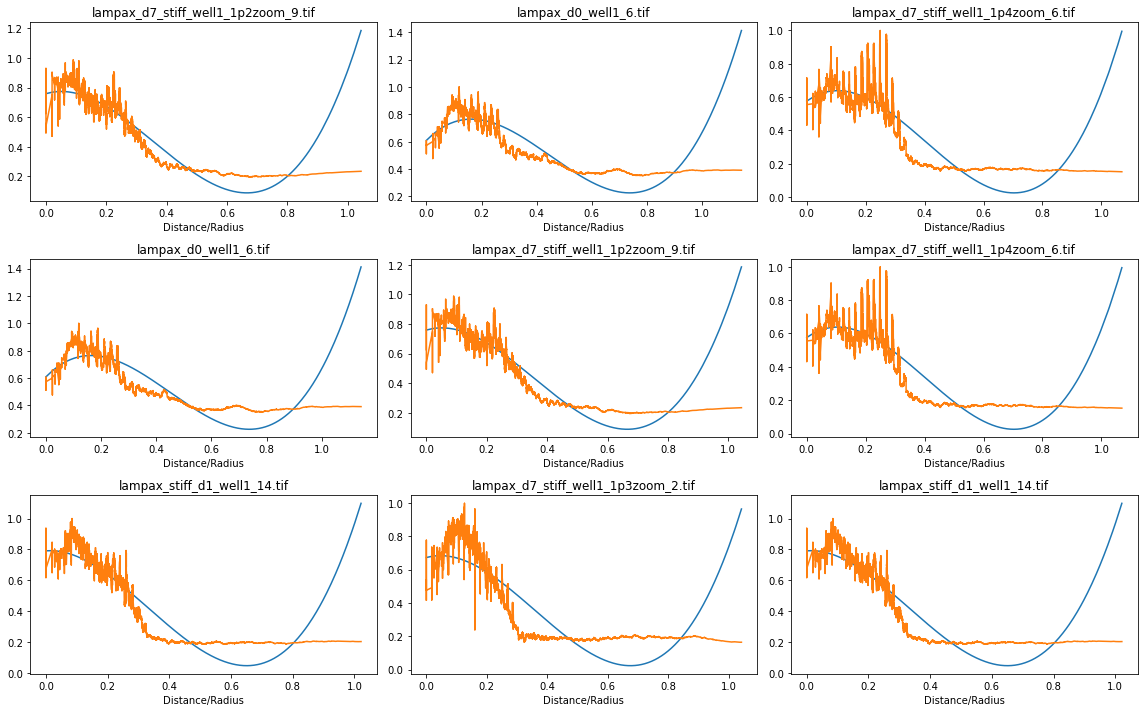

In [ ]:
plot_cluster_images(2)

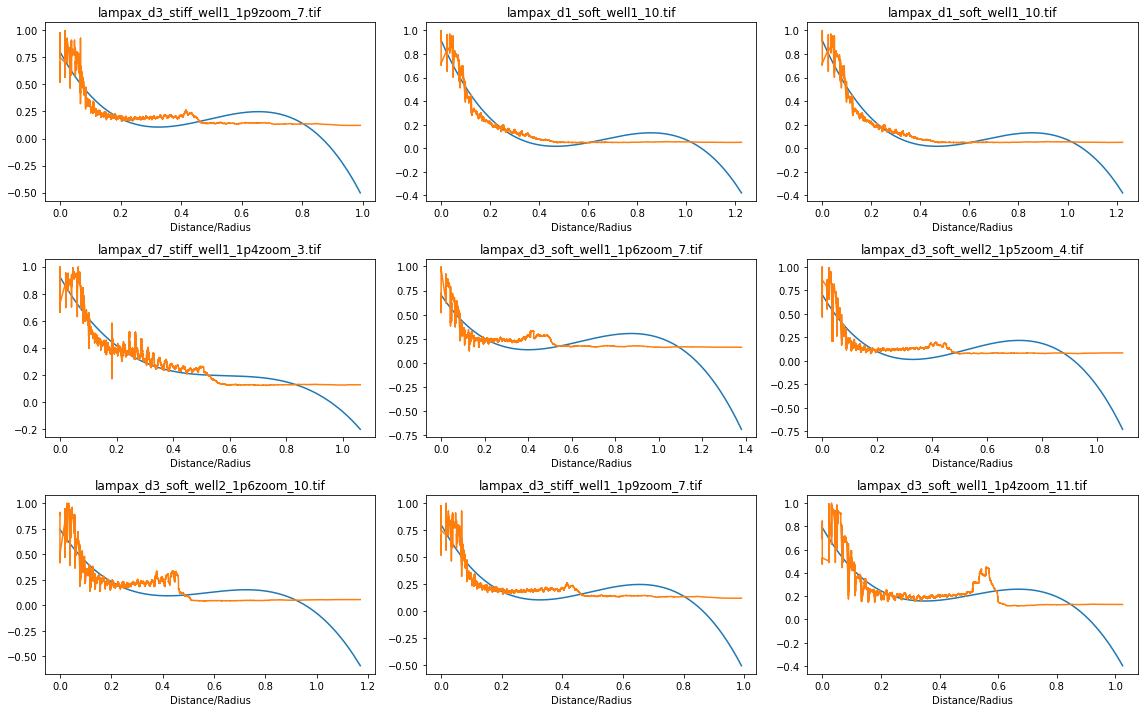

In [ ]:
plot_cluster_images(3)

In [75]:
pca = Pipeline([
    ('Scaler', StandardScaler()),
    ('PCA', PCA(n_components=2))
])

curve_fit_data[['pc_1', 'pc_2']] = pca.fit_transform(curve_fit_data.iloc[:, :-1])

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [45]:
curve_fit_data.head()

,coef_4,coef_3,coef_2,coef_1,coef_0,cluster
Image,,,,,,
lam_pax_d3_soft_well1_1p6zoom_8.tif,2.930802,-8.546365,8.688102,-3.670119,0.734701,1
lam_pax_d7_soft_well1_1p4zoom_4.tif,0.759171,-3.653723,5.484231,-3.216464,0.724886,1
lampax_d0_well1_1.tif,14.025379,-31.153130,24.172974,-7.825265,0.992207,2
lampax_d0_well1_10.tif,0.792651,-3.641396,5.624736,-3.365425,0.917756,1
lampax_d0_well1_11.tif,-0.772565,0.335262,2.122413,-2.409417,0.876184,1


<AxesSubplot:xlabel='pc_1', ylabel='pc_2'>

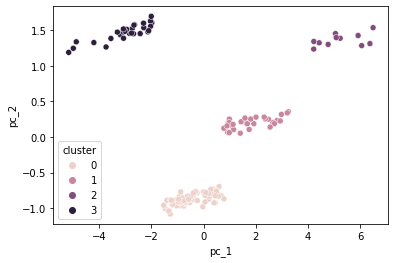

In [ ]:
sns.scatterplot(data=curve_fit_data, x='pc_1', y='pc_2', hue='cluster')

In [24]:
total.to_csv("ALLDATA.csv")

In [ ]:
def category(image):
    

In [88]:
def category(row):
    if "d0" in row["Image"]:
        return "d0"
    elif "d1" in row["Image"]:
        if "soft" in row["Image"]:
            return "d1 Soft"
        else:
            return "d1 Stiff"
    elif "d3" in row["Image"]:
        if "soft" in row["Image"]:
            return "d3 Soft"
        else:
            return "d3 Stiff"  
    elif "d7" in row["Image"]:
        if "soft" in row["Image"]:
            return "d7 Soft"
        else:
            return "d7 Stiff"

def get_category(image):
    if 'd0' in image:
        return 'd0'
    elif 

In [94]:
curve_fit_data = curve_fit_data.reset_index()

In [98]:
curve_fit_data['Category'] = curve_fit_data.apply(lambda row: category(row), axis=1)

In [105]:
pivot_table = curve_fit_data.groupby('Category').cluster.value_counts(normalize=True)
pivot_table.name = 'Percentage'
pivot_table = pivot_table.reset_index()

In [109]:
pivot_table.sort_values(['Category', 'cluster'])

,Category,cluster,Percentage
1,d0,0,0.263158
0,d0,1,0.421053
2,d0,2,0.263158
3,d0,3,0.052632
6,d1 Soft,0,0.095238
4,d1 Soft,1,0.714286
5,d1 Soft,2,0.190476
8,d1 Stiff,0,0.285714
7,d1 Stiff,1,0.571429
10,d1 Stiff,2,0.047619


In [ ]:
pd.pivot_table(pivot_table, index='')

<AxesSubplot:xlabel='pc_1', ylabel='pc_2'>

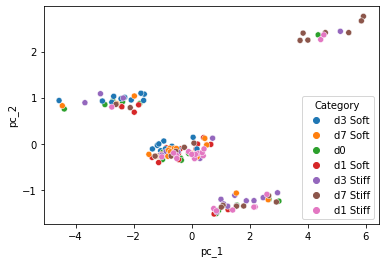

In [101]:
sns.scatterplot(data=curve_fit_data, x='pc_1', y='pc_2', hue='Category')